In [1]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 54.0 MB/s eta 0:00:00


In [ ]:
pip install --upgrade scikit-image

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import pydicom
import os
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation
import matplotlib.pyplot as plt
from skimage.segmentation import watershed

import time

In [ ]:
INPUT_FOLDER = '/content/pasien'

patients = os.listdir(INPUT_FOLDER)
patients.sort()

print("Some examples of patient IDs:")
print(",\n".join(patients[:10]))

Some examples of patient IDs:
1,
10,
2,
3,
4,
5,
6,
7,
8,
9


In [ ]:
def load_image(path):
    """
    Loads PNG image as grayscale.

    Parameters: path (Image path)

    Returns: image (NumPy array)
    """
    from skimage.io import imread
    image = imread(path, as_gray=True)
    return image

patient_folder_path = os.path.join(INPUT_FOLDER, patients[4])  # Path pasien pertama
for file in os.listdir(patient_folder_path):
    file_path = os.path.join(patient_folder_path, file)
    try:
        image = load_image(file_path)
        print(f"Successfully read: {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

Successfully read: IM-0160-0001.dcm.png


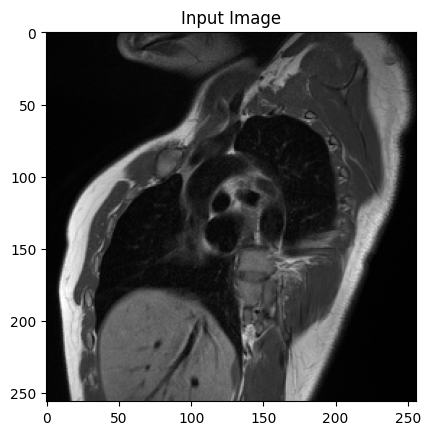

In [ ]:
# Memastikan pasien tersedia
if len(patients) > 0:
    patient_folder_path = os.path.join(INPUT_FOLDER, patients[4])

    # Memuat data PNG
    test_patient_image = load_image(os.path.join(patient_folder_path, os.listdir(patient_folder_path)[0]))

    if test_patient_image is not None:
        plt.imshow(test_patient_image, cmap='gray')
        plt.title("Input Image")
        plt.savefig('slice_index.png')  # Simpan sebagai PNG
        plt.show()


In [ ]:
def generate_markers(image):
    """
    Generates markers for a given image.

    Parameters:
    image (numpy array): Input image for marker generation.

    Returns:
    tuple: Internal Marker, External Marker, and Watershed Marker.
    """

    # Creation of the internal Marker
    marker_internal = image < 0.10  # Threshold for internal marker
    marker_internal = segmentation.clear_border(marker_internal)  # Remove border artifacts
    marker_internal_labels = measure.label(marker_internal)  # Label connected components

    # Sort regions by area and remove the smallest regions
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()

    if len(areas) > 2:
    # Menghitung indeks tengah
     middle_index = len(areas) // -2
     middle_value = areas[middle_index]

     for region in measure.regionprops(marker_internal_labels):
        if region.area < middle_value:  # Membandingkan dengan nilai tengah
            for coordinates in region.coords:
                marker_internal_labels[coordinates[0], coordinates[1]] = 0  # Hapus wilayah kecil


    marker_internal = marker_internal_labels > 0  # Keep only labeled regions

    # Creation of the External Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)  # Dilate internal marker
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)  # Dilate further
    marker_external = external_b ^ external_a  # XOR operation to create external marker

    # Creation of the Watershed Marker
    marker_watershed = np.zeros(image.shape, dtype=int)  # Initialize empty marker (use int for dtype)
    marker_watershed += marker_internal * 200  # Internal marker in watershed
    marker_watershed += marker_external * 100 # External marker in watershed

    return marker_internal, marker_external, marker_watershed

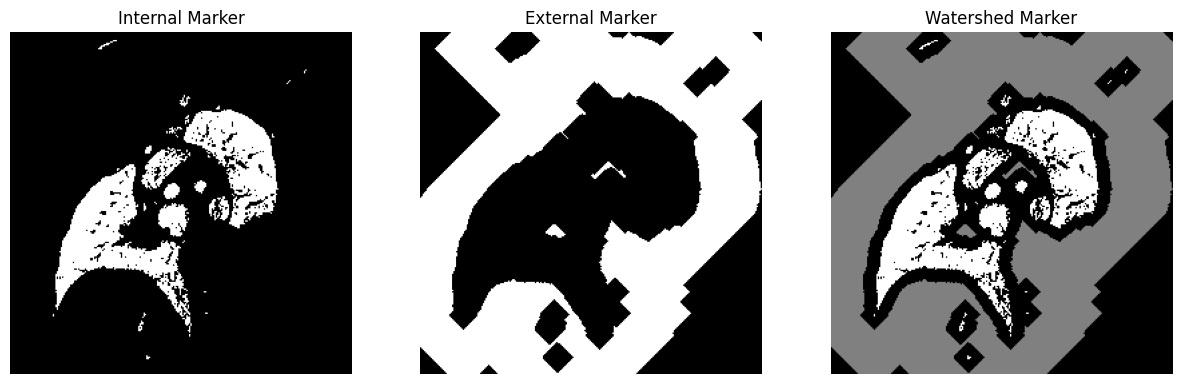

In [ ]:
# Use the input image for marker generation
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_image)

# Plot the markers
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))

ax1.imshow(test_patient_internal, cmap='gray')
ax1.set_title("Internal Marker")
ax1.axis('off')

ax2.imshow(test_patient_external, cmap='gray')
ax2.set_title("External Marker")
ax2.axis('off')

ax3.imshow(test_patient_watershed, cmap='gray')
ax3.set_title("Watershed Marker")
ax3.axis('off')

plt.savefig('markers_output.png')  # Simpan sebagai PNG


In [ ]:
# Lists to store computation times and iterations
computation_times = []
iteration_titles = []

In [ ]:
def segment_cardiac(image, iterations=1):
    """
    Segments cardiac region using various techniques.

    Parameters: image (Scan image), iterations (more iterations, more accurate mask)

    Returns:
        - Segmented Cardiac
        - Cardiac Filter
        - Outline Cardiac
        - Watershed Cardiac
        - Sobel Gradient
    """

    # Store the start time
    start = time.time()

    marker_internal, marker_external, marker_watershed = generate_markers(image)

    '''
    Creation of Sobel Gradient
    '''

    # Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)

    '''
    Using the watershed algorithm
    We pass the image convoluted by sobel operator and the watershed marker
    to watershed from skimage.segmentation to get a matrix labeled using the watershed segmentation algorithm.
    '''
    watershed_result = watershed(sobel_gradient, marker_watershed)

    '''
    Reducing the image to outlines after Watershed algorithm
    '''
    outline = ndimage.morphological_gradient(watershed_result, size=(3,3))
    outline = outline.astype(bool)

    '''
    Black Top-hat Morphology:
    '''

    # Structuring element used for the filter
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]

    blackhat_struct = ndimage.iterate_structure(blackhat_struct, iterations)

    # Perform Black Top-hat filter
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)

    '''
    Generate cardiac filter using internal marker and outline.
    '''
    cardiac_filter = np.bitwise_or(marker_internal, outline)
    cardiac_filter = ndimage.binary_closing(cardiac_filter, structure=np.ones((5,5)), iterations=3)

    '''
    Segment cardiac region using cardiac filter and the image.
    '''

    # Ensure both arrays have the same shape
    if image.shape != cardiac_filter.shape:
        image = np.resize(image, cardiac_filter.shape)

    # Segment the image
    segmented = np.where(cardiac_filter == 1, image, -2000*np.ones(cardiac_filter.shape))

    # Append computation time
    end = time.time()
    computation_times.append(end - start)
    iteration_titles.append("{num} iterations".format(num=iterations))

    return segmented, cardiac_filter, outline, watershed_result, sobel_gradient


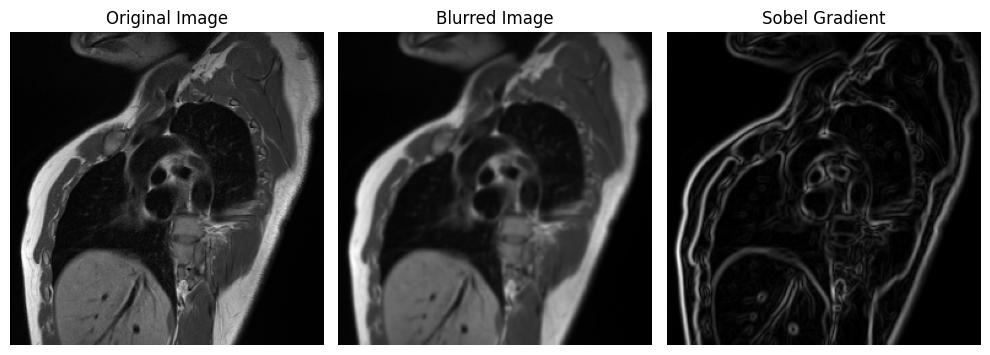

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Baca gambar asli
image = cv2.imread('/content/pasien/4/IM-0160-0001.dcm.png', cv2.IMREAD_GRAYSCALE)

# Terapkan Gaussian Blur untuk mengurangi noise
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Terapkan Sobel Gradient
sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
sobel_gradient = cv2.magnitude(sobel_x, sobel_y)

# Normalisasi hasil Sobel Gradient
sobel_normalized = cv2.normalize(sobel_gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Plot hasil
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Blurred Image")
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Sobel Gradient")
plt.imshow(sobel_normalized, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Periksa bentuk gambar
if test_patient_image.ndim == 3:  # Jika memiliki dimensi batch
    single_image = test_patient_image[0]
else:
    single_image = test_patient_image

# Jika gambar berwarna, konversi ke grayscale
if single_image.ndim == 3:
    single_image = np.mean(single_image, axis=2)

# Jalankan segmentasi
for itrs in range(1, 9):
    test_segmented, test_cardiacfilter, test_outline, test_watershed, test_sobel_gradient = segment_cardiac(single_image, itrs)



In [ ]:
itr_dict = {'Iterations': iteration_titles, 'Computation Times (in seconds)': computation_times}

colors = ['#30336b',] * 8
colors[0] = '#eb4d4b'

import plotly.graph_objects as go

# Plotting the iteration vs computation time chart
fig = go.Figure(data=[go.Bar(
    x=itr_dict['Iterations'],
    y=itr_dict['Computation Times (in seconds)'],
    marker_color=colors
)])
fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')

fig.update_layout(
    title='Iterations vs Computation Times (Cardiac)',
    yaxis=dict(
        title='Computation Times (in seconds)',
        titlefont_size=16,
        tickfont_size=14,
    ),
    autosize=False,
    width=800,
    height=800
)

fig.show()

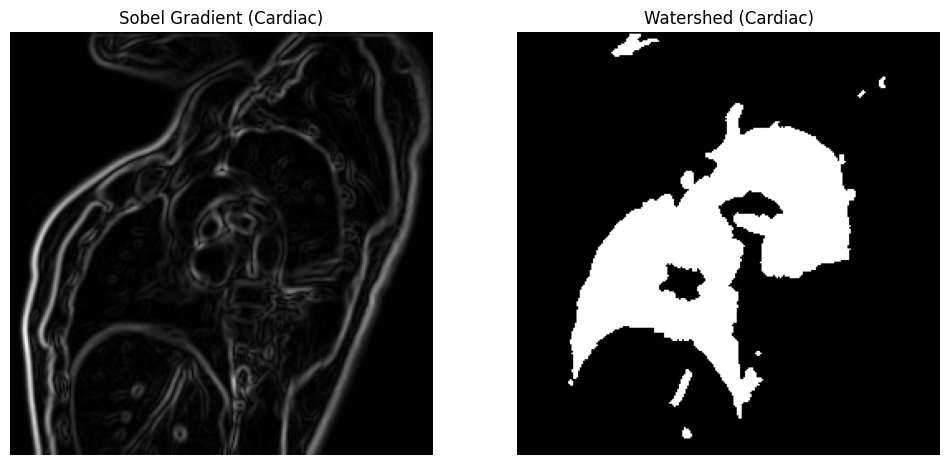

In [ ]:
# Displaying Sobel Gradient and Watershed images for cardiac data
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 12))

ax1.imshow(sobel_normalized, cmap='gray')
ax1.set_title("Sobel Gradient (Cardiac)")
ax1.axis('off')

ax2.imshow(test_watershed, cmap='gray')
ax2.set_title("Watershed (Cardiac)")
ax2.axis('off')

plt.show()

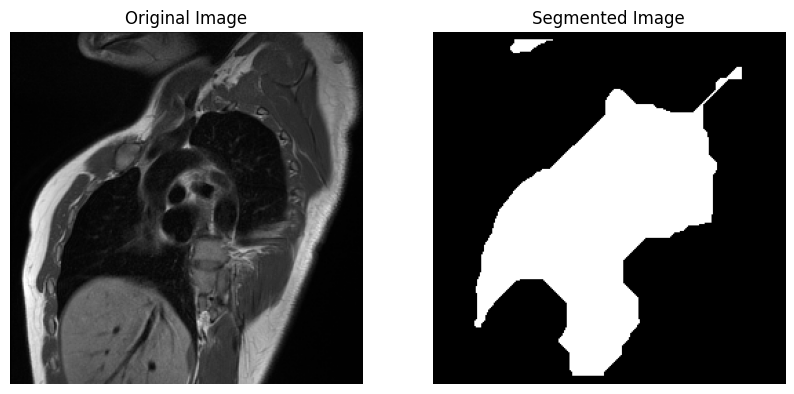

In [ ]:
4# Plot gambar asli dan hasil segmentasi
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(test_patient_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmented Image")
plt.imshow(test_segmented, cmap='gray')
plt.axis('off')

plt.show()


In [ ]:
def dice_coefficient(mask1, mask2):
    """
    Menghitung Dice Similarity Coefficient (DSC) antara dua mask biner.
    Parameters:
    - mask1: Mask biner pertama
    - mask2: Mask biner kedua
    Returns:
    - dice: Nilai DSC (float)
    """
    intersection = np.sum(mask1 * mask2)
    union = np.sum(mask1) + np.sum(mask2)
    dice = (2.0 * intersection) / union if union > 0 else 0
    return dice


In [ ]:
# Iterasi segmentasi
dice_scores = []  # Untuk menyimpan nilai Dice Similarity

for itrs in range(1, 9):
    test_segmented, test_cardiacfilter, test_outline, test_watershed, test_sobel_gradient = segment_cardiac(single_image, itrs)

    # Hitung Dice Similarity terhadap iterasi pertama
    if itrs == 1:
        reference_mask = test_cardiacfilter
    else:
        dice = dice_coefficient(reference_mask, test_cardiacfilter)
        dice_scores.append(dice)


In [ ]:
# Iterasi segmentasi
dice_scores = []  # Untuk menyimpan nilai Dice Similarity

for itrs in range(1, 9):
    test_segmented, test_cardiacfilter, test_outline, test_watershed, test_sobel_gradient = segment_cardiac(single_image, itrs)

    # Hitung Dice Similarity terhadap iterasi pertama
    if itrs == 1:
        reference_mask = test_cardiacfilter
    else:
        dice = dice_coefficient(reference_mask, test_cardiacfilter)
        dice_scores.append(dice)


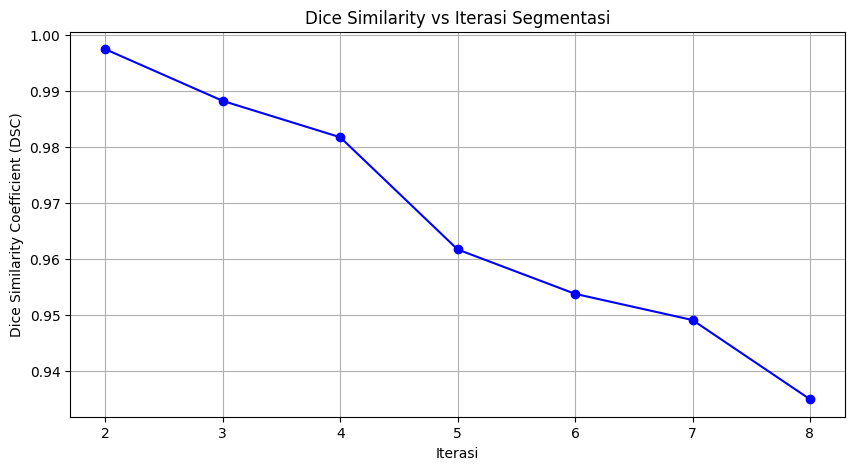

In [ ]:
# Plotting Dice Similarity vs Iterasi
plt.figure(figsize=(10, 5))
plt.plot(range(2, 9), dice_scores, marker='o', linestyle='-', color='b')
plt.title("Dice Similarity vs Iterasi Segmentasi")
plt.xlabel("Iterasi")
plt.ylabel("Dice Similarity Coefficient (DSC)")
plt.grid(True)
plt.show()


In [ ]:
from skimage.measure import regionprops, label

def evaluate_geometric_properties(mask):
    """
    Mengevaluasi properti geometris dari hasil segmentasi.
    Parameters:
    - mask: Mask hasil segmentasi (biner)
    Returns:
    - properties: Daftar properti region
    """
    labeled_mask = label(mask)
    properties = regionprops(labeled_mask)

    for i, prop in enumerate(properties):
        print(f"Region {i + 1}:")
        print(f"  - Area: {prop.area}")
        print(f"  - Perimeter: {prop.perimeter}")
        print(f"  - Eccentricity: {prop.eccentricity}")
        print(f"  - Solidity: {prop.solidity}")
        print("")

    return properties


In [ ]:
# Evaluasi hasil iterasi terakhir
evaluate_geometric_properties(test_cardiacfilter)


Region 1:
  - Area: 183.0
  - Perimeter: 64.59188309203678
  - Eccentricity: 0.9433530731692129
  - Solidity: 0.8551401869158879

Region 2:
  - Area: 18571.0
  - Perimeter: 807.9087296526012
  - Eccentricity: 0.7905594683530199
  - Solidity: 0.701666225866173



In [ ]:
def compactness(binary_mask):
    """
    Menghitung compactness dari mask biner.
    Compactness = Perimeter^2 / Area
    """
    labeled_mask = measure.label(binary_mask)
    regions = regionprops(labeled_mask)

    for region in regions:
        perimeter = region.perimeter
        area = region.area
        if area > 0:
            comp = (perimeter**2) / area
            print(f"Compactness: {comp:.2f}")
compactness(test_cardiacfilter)


Compactness: 45.43


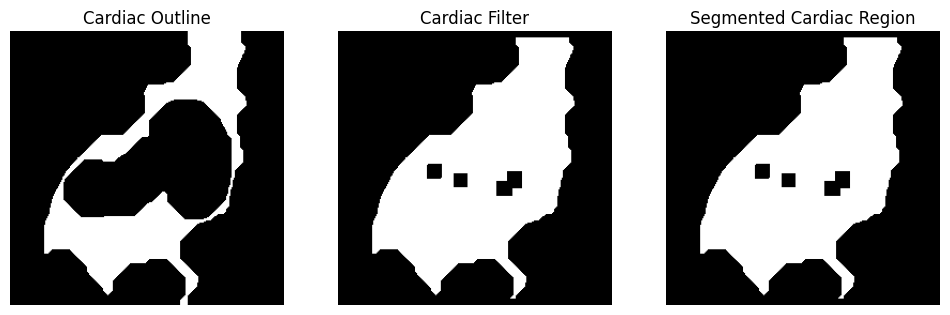

In [ ]:
# Visualizing Outline, Cardiac Filter, and Segmented images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 12))

ax1.imshow(test_outline, cmap='gray')
ax1.set_title("Cardiac Outline")
ax1.axis('off')

ax2.imshow(test_cardiacfilter, cmap='gray')
ax2.set_title("Cardiac Filter")
ax2.axis('off')

ax3.imshow(test_segmented, cmap='gray')
ax3.set_title("Segmented Cardiac Region")
ax3.axis('off')

plt.show()

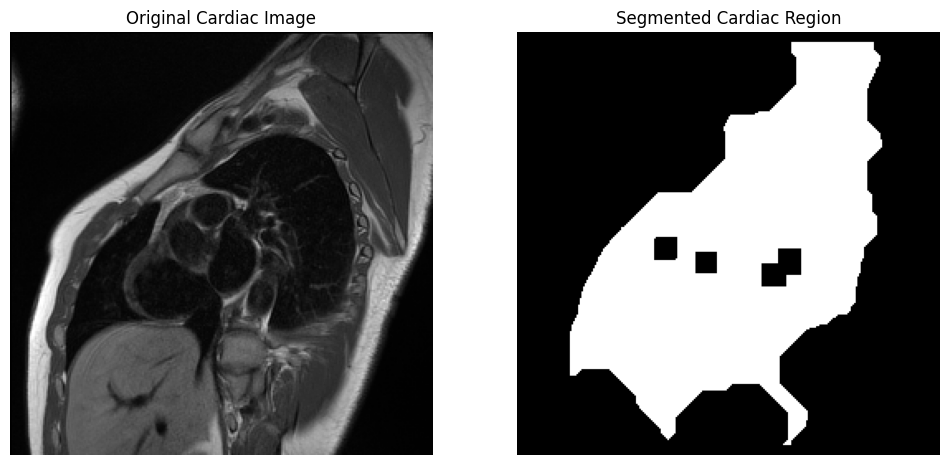

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 12))

ax1.imshow(test_patient_image, cmap='gray')
ax1.set_title("Original Cardiac Image")
ax1.axis('off')

ax2.imshow(test_segmented, cmap='gray')
ax2.set_title("Segmented Cardiac Region")
ax2.axis('off')

plt.show()
